In [5]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import TensorDataset, DataLoader, random_split
# from networks import Model
# from dropout import *

from data import generate_data
# from train import train_main_model, train_deup
# from utils import inv_sigmoid, evaluate_and_plot, eval_error

import itertools

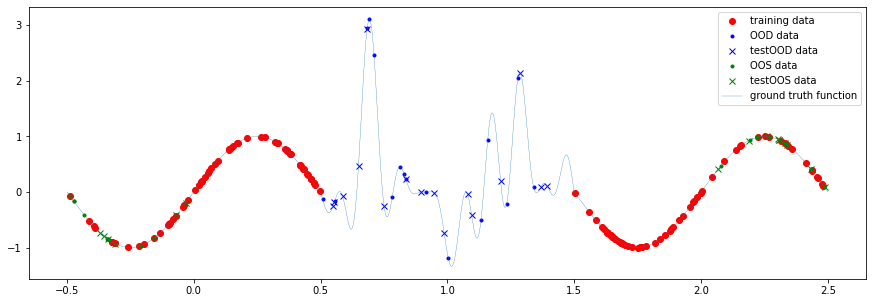

In [7]:
(x, y, oos_x, oos_y, ood_x, ood_y, oos_x_test,
 oos_y_test, ood_x_test, ood_y_test, x_test, y_test) = generate_data(128, 32, 32, seed=7, plot=True, shuffle=True)

full_X = torch.cat((x, ood_x, oos_x))
full_Y= torch.cat((y, ood_y, oos_y))
full_data = TensorDataset(full_X, full_Y)

test_data = TensorDataset(torch.cat((ood_x_test, oos_x_test)), torch.cat((ood_y_test, oos_y_test)))
oos_ood = torch.cat((ood_x, oos_x)), torch.cat((ood_y, oos_y))

In [8]:
main_net = nn.Sequential(nn.Linear(1, 256),
                         nn.ReLU(),
                         nn.Linear(256, 256),
                         nn.ReLU(),
                         nn.Linear(256, 128))

class noise_net(nn.Module):
    def __init__(self, noise_dim, width=256):
        super().__init__()
        self.noise_layer = nn.Linear(noise_dim, width, bias=False)
        self.x_layer = nn.Linear(1, 128, bias=True)
        self.hidden_layer_1 = nn.Linear(128, width, bias=True)
        self.hidden_layer_2 = nn.Linear(width, width, bias=False)
        self.output_layer = nn.Linear(width, 128, bias=False)
    
    def forward(self, x, noise):
        out = F.relu(self.x_layer(x))
        out = F.relu(self.hidden_layer_1(out)) * self.noise_layer(noise)
        out = F.relu(self.hidden_layer_2(out))
        return 1+self.output_layer(out)

output_net = nn.Sequential(nn.Linear(128, 64),
                           nn.ReLU(),
                           nn.Linear(64, 1))



In [9]:
from torch.utils.data import TensorDataset, DataLoader

train_data = TensorDataset(x, y)

mu = main_net
#sigma = noise_net().cuda()
out = output_net

optimizer = torch.optim.Adam(itertools.chain(mu.parameters(), out.parameters()), lr=0.002)
loss_fn = nn.MSELoss()

gamma = 0.5

loader = DataLoader(train_data, shuffle=True, batch_size=64)
losses = []
valid_losses = []
for epoch in range(500):
    epoch_losses = []
    for batch_id, (xi, yi) in enumerate(loader):
        optimizer.zero_grad()
        
        # E_Z(F(x, Z)) == \mu(x)
        #z = torch.randn(len(xi), noise_dim).cuda()
        y_hat = out(mu(xi)) # * sigma(xi, z)
        
        # E_Z((F(x, Z)-F(x, 0))(F(x', Z)-F(x', 0))) == E_{y,y'}(r(x, y)r(x',y'))
        '''
        z_prime = torch.randn(len(xi) // 2, 10).cuda()
        xi_1, xi_2 = xi[:len(xi)//2], xi[len(xi)//2:]
        yi_1, yi_2 = yi[:len(yi)//2], yi[len(yi)//2:]
        mu_1 = out(mu(xi_1))
        mu_2 = out(mu(xi_2))
        r_hat_1 = out(mu(xi_1) * sigma(xi_1, z_prime)) - mu_1
        r_hat_2 = out(mu(xi_2) * sigma(xi_2, z_prime)) - mu_2
        r_1 = yi_1 - mu_1
        r_2 = yi_2 - mu_2
        '''
        f_loss = loss_fn(y_hat, yi) #+ gamma * loss_fn(r_hat_1*r_hat_2, r_1*r_2)
        epoch_losses.append(f_loss.item() * xi.shape[0])
        f_loss.backward()
        optimizer.step()
    losses.append(np.sum(epoch_losses) / train_data[:][0].shape[0])

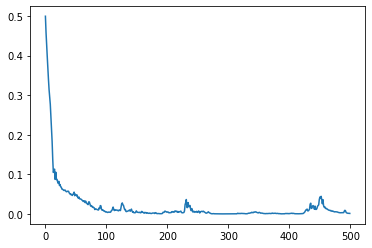

In [10]:
plt.plot(losses)

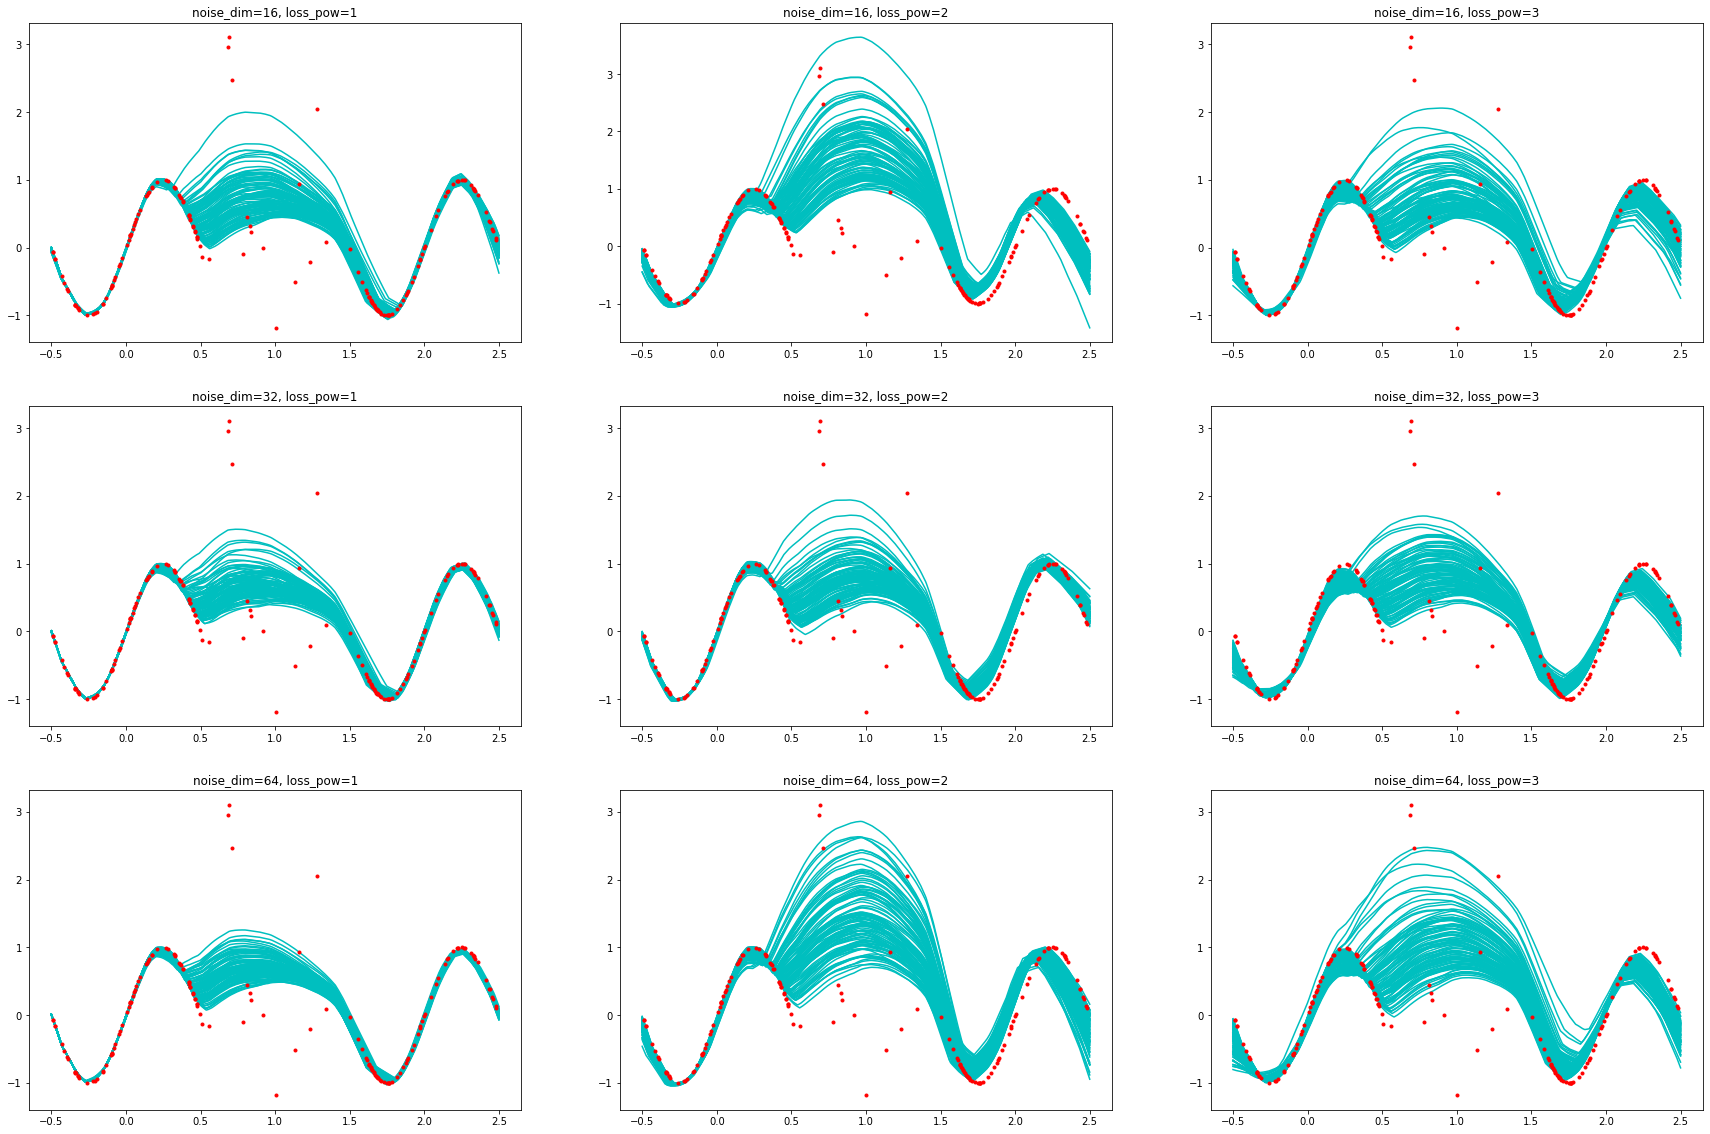

In [40]:
plt.figure(figsize=(30, 20))

plot_i = 1
for noise_dim in [16, 32, 64]:
    for loss_pow in [1, 2, 3]:
        
        plt.subplot(3, 3, plot_i)
        
        sigma = noise_net(noise_dim=noise_dim, width=256).cuda()
        optimizer = torch.optim.Adam(itertools.chain(sigma.parameters()), lr=0.001)

        oos_data = TensorDataset(torch.cat([oos_x,ood_x, x]), torch.cat([oos_y, ood_y, y]))
        deup_losses = []
        gamma = 1
        beta = 1
        loader = DataLoader(oos_data, shuffle=True, batch_size=128)
        for epoch in range(100):
            epoch_losses = []
            for batch_id, (xi, yi) in enumerate(loader):
                optimizer.zero_grad()

                # E_Z(F(x, Z)) == \mu(x)
                #z = torch.randn(len(xi), noise_dim).cuda()
                #y_hat = out(mu(xi) * sigma(xi, z))

                # E_Z((F(x, Z)-F(x, 0))(F(x', Z)-F(x', 0))) == E_{y,y'}(r(x, y)r(x',y'))
                z_prime = torch.randn(len(xi) // 2, noise_dim).cuda()
                xi_1, xi_2 = xi[:len(xi)//2], xi[len(xi)//2:]
                yi_1, yi_2 = yi[:len(yi)//2], yi[len(yi)//2:]
                mu_1 = out(mu(xi_1))
                mu_2 = out(mu(xi_2))
                r_hat_1 = out(mu(xi_1) * sigma(xi_1, z_prime))  - mu_1
                r_hat_2 = out(mu(xi_2) * sigma(xi_2, z_prime)) - mu_2
                r_1 = yi_1 - mu_1
                r_2 = yi_2 - mu_2

                #print(r_hat_1*r_hat_2, r_1*r_2)
                f_loss = gamma * loss_fn((r_hat_1*r_hat_2)**loss_pow, (r_1*r_2)**loss_pow) + \
                         beta * loss_fn(r_hat_1**loss_pow, r_1**loss_pow) + \
                         beta * loss_fn(r_hat_2**loss_pow, r_2**loss_pow)
                #f_loss = loss_fn(r_hat_1*r_hat_2, r_1*r_2)
                epoch_losses.append(f_loss.item() * xi.shape[0])
                f_loss.backward()
                optimizer.step()
            deup_losses.append(np.sum(epoch_losses) / train_data[:][0].shape[0])
        
        # plotting
        for _ in range(100):
            z = torch.randn(1, noise_dim).repeat(len(x_test), 1).cuda()
            non_dropout_pred = (out(mu(x_test)*sigma(x_test, z))).detach()
            plt.plot(x_test.cpu(), non_dropout_pred.cpu(), 'c')

        plt.plot(full_X.cpu(), full_Y.cpu(), 'r.', label='train_data')
        plt.title(f'noise_dim={noise_dim}, loss_pow={loss_pow}')
        plot_i += 1

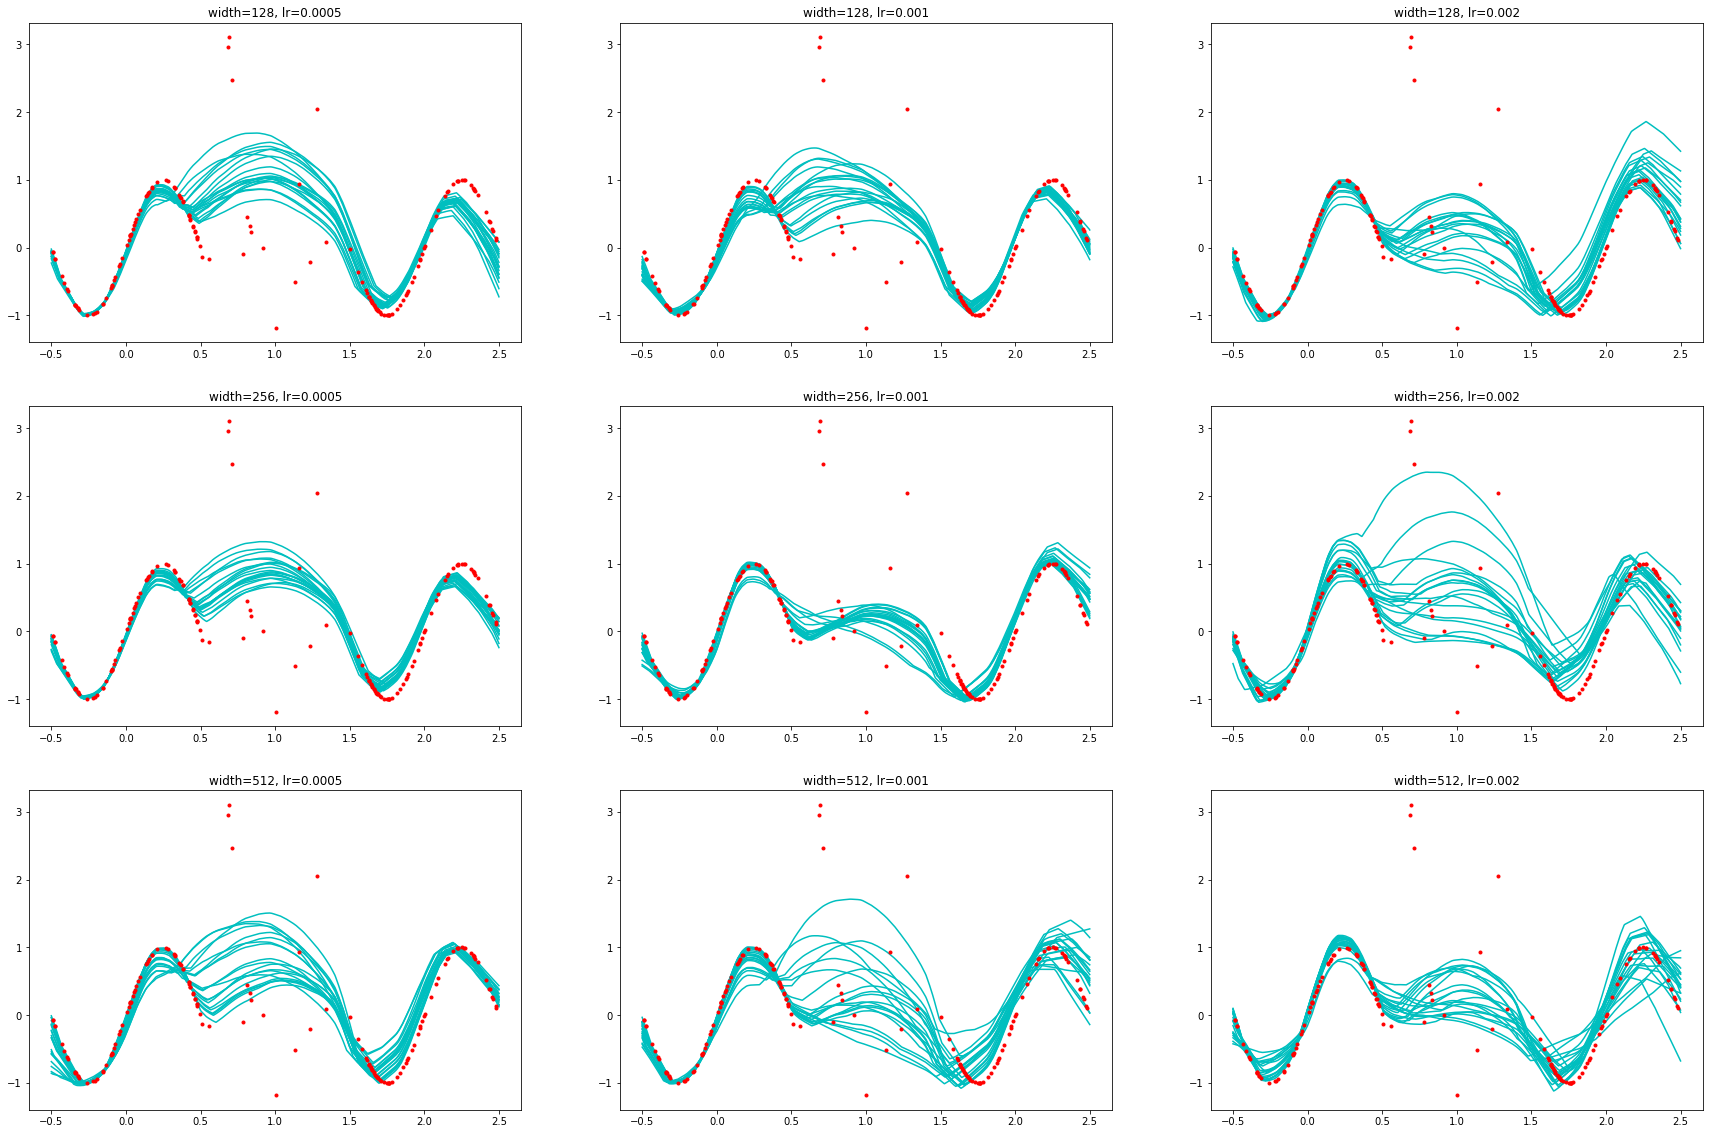

In [41]:
plt.figure(figsize=(30, 20))

plot_i = 1

loss_pow = 3
noise_dim = 64
batch_size = 32
gamma = 1
beta = 1

for width in [128, 256, 512]:
    for lr in [0.0005, 0.001, 0.002]:
        plt.subplot(3, 3, plot_i)
        
        sigma = noise_net(noise_dim=noise_dim, width=width).cuda()
        optimizer = torch.optim.Adam(itertools.chain(sigma.parameters()), lr=lr)

        oos_data = TensorDataset(torch.cat([oos_x,ood_x, x[:256]]), torch.cat([oos_y, ood_y, y[:256]]))
        deup_losses = []
        loader = DataLoader(oos_data, shuffle=True, batch_size=batch_size)
        for epoch in range(150):
            epoch_losses = []
            for batch_id, (xi, yi) in enumerate(loader):
                optimizer.zero_grad()

                # E_Z(F(x, Z)) == \mu(x)
                #z = torch.randn(len(xi), noise_dim).cuda()
                #y_hat = out(mu(xi) * sigma(xi, z))

                # E_Z((F(x, Z)-F(x, 0))(F(x', Z)-F(x', 0))) == E_{y,y'}(r(x, y)r(x',y'))
                z_prime = torch.randn(len(xi) // 2, noise_dim).cuda()
                xi_1, xi_2 = xi[:len(xi)//2], xi[len(xi)//2:]
                yi_1, yi_2 = yi[:len(yi)//2], yi[len(yi)//2:]
                mu_1 = out(mu(xi_1))
                mu_2 = out(mu(xi_2))
                r_hat_1 = out(mu(xi_1) * sigma(xi_1, z_prime))  - mu_1
                r_hat_2 = out(mu(xi_2) * sigma(xi_2, z_prime)) - mu_2
                r_1 = yi_1 - mu_1
                r_2 = yi_2 - mu_2

                #print(r_hat_1*r_hat_2, r_1*r_2)
                f_loss = gamma * loss_fn((r_hat_1*r_hat_2)**loss_pow, (r_1*r_2)**loss_pow) + \
                         beta * loss_fn(r_hat_1**loss_pow, r_1**loss_pow) + \
                         beta * loss_fn(r_hat_2**loss_pow, r_2**loss_pow)
                #f_loss = loss_fn(r_hat_1*r_hat_2, r_1*r_2)
                epoch_losses.append(f_loss.item() * xi.shape[0])
                f_loss.backward()
                optimizer.step()
            deup_losses.append(np.sum(epoch_losses) / train_data[:][0].shape[0])
        
        # plotting
        for _ in range(20):
            z = torch.randn(1, noise_dim).repeat(len(x_test), 1).cuda()
            non_dropout_pred = (out(mu(x_test)*sigma(x_test, z))).detach()
            plt.plot(x_test.cpu(), non_dropout_pred.cpu(), 'c')

        plt.plot(full_X.cpu(), full_Y.cpu(), 'r.', label='train_data')
        plt.title(f'width={width}, lr={lr}')
        plot_i += 1

In [ ]:
plt.plot(losses, label='train losses')
plt.plot(deup_losses, label='deup losses')
#plt.plot(valid_losses, label='valid losses')
plt.legend()

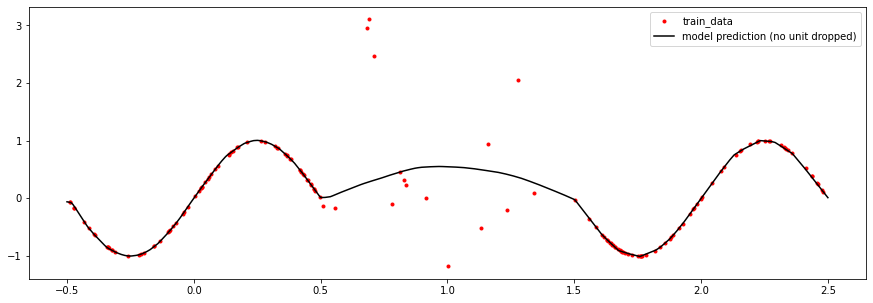

In [35]:
plt.figure(figsize=(15, 5))
non_dropout_pred = out(mu(x_test)).detach()

plt.plot(full_X.cpu(), full_Y.cpu(), 'r.', label='train_data')

plt.plot(x_test.cpu(), non_dropout_pred.cpu(), 'k', label='model prediction (no unit dropped)')

plt.legend()
plt.show()

In [ ]:
plt.figure(figsize=(15, 5))

for _ in range(100):
    z = torch.randn(1, noise_dim).repeat(len(x_test), 1).cuda()
    non_dropout_pred = (out(mu(x_test))*sigma(x_test, z)).detach()
    plt.plot(x_test.cpu(), non_dropout_pred.cpu(), 'c')

plt.plot(full_X.cpu(), full_Y.cpu(), 'r.', label='train_data')

plt.legend()
plt.show()

In [ ]:
plt.figure(figsize=(15, 5))
z = torch.randn(1, noise_dim).repeat(len(x_test), 1).cuda()
non_dropout_pred = sigma(x_test, z).detach()

plt.plot(torch.cat([oos_x,ood_x]).cpu(), torch.cat([oos_y,ood_y]).cpu(), 'r.', label='train_data')

plt.plot(x_test.cpu(), non_dropout_pred.cpu(), 'k', label='model prediction (no unit dropped)')

plt.legend()
plt.show()